

## **Deep Learning assignment: 03**
### Author: Muhammad Faizan
engrfaizan.ai@gmail.com
# *MS Robotics & AI, School of Mechanical and Manufacturing Engineering, NUST, Islamabad.*

---




*   Create a CNN network architecture with the CIFAR-10 dataset using your registration no. x  7.8 as reference.
*   Calculate the memory cost and no. of instructions for Alexnet.
*   Calculate the time it would take for a i3 1st gen system to process AlexNet.
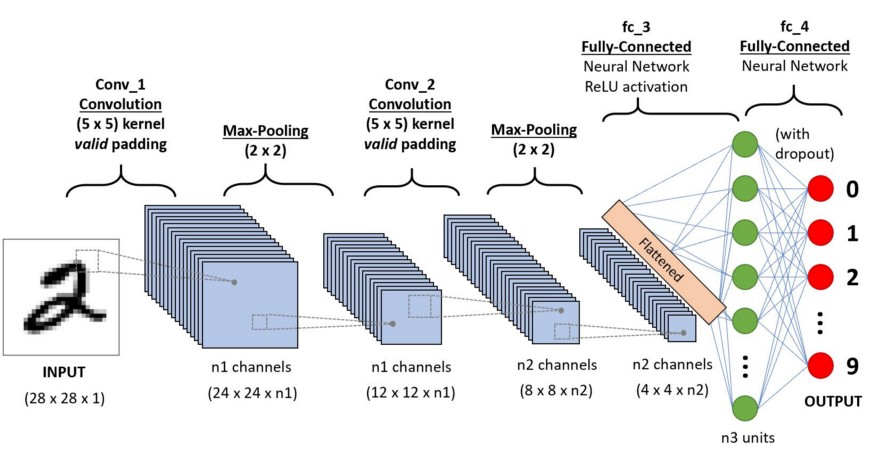



## ***Create a CNN network architecture with the CIFAR-10 dataset using your registration no. x 7.8 as reference***.


1.   Based on my registration number 400941, the resulted number: 3,127,339
2.   Since there are seven digits and I have to convert (round up) enven digits to odd ones for selecting the kernel size because conventionally odd filter sizes are being used in the literature.
3. Thefore, the resutlted number becomes 3, 137, 339.
4. This mean I will use CNN architecture of seven layers with filter or kernel size of 3 in the first layer, 1 in the second layer, 3 in the third layers, and so on.
5. if the kernel size is too big and the input image is small in spatial size then we have to decrease kernel to a smaller odd digit value.
6. Finally we can use fully connected layers at the end for classification and recognition.
7. dropout is a good addition in the architecure since it avoids overfitting issues.
8. MaxPooling and batch normalization are good practices in deep leanring, so we will using them.
9. We will using sparse categorical cross entropy loss for measuring the difference between the ground truth adn prediction.
10. Data augmentation will be used to create diversity and avoid class imblance and overfitting issue if the dataset.
11. Implementation framework is PyTorch.



tree structure





In [2]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00




directory tree structure of the assignment


In [3]:
# necessary imports
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
import math
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import wandb
from tqdm import tqdm

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as tf
import torchvision.datasets as ds
from torch.autograd import Variable

In [4]:
# Data Loading and data transforms
## here we define data augmentataion, common pytorch transforms like conversion to tensors and load dataset

# define simple transforms for without data augmentation training and comparison
transforms = tf.Compose([tf.ToTensor(),
                         tf.Normalize(mean = [0.5, 0.5, 0.5],
                                      std  = [0.5, 0.5, 0.5])])




# now load the dataset from teh pytorchs torchvision
train_cifar10 = ds.CIFAR10(root= './data', train= True,
                     transform= transforms,
                     download = True)
test_cifar10 = ds.CIFAR10(root = './data', train = False,
                          transform = transforms, download = True)





# now load the dataset in batches
train_loader = DataLoader(train_cifar10, batch_size = 32,
                          shuffle = True, num_workers = 2,
                          pin_memory = True, drop_last = True)

test_loader = DataLoader(test_cifar10, batch_size = 32,
                          shuffle = False, num_workers = 2,
                          pin_memory = True, drop_last = True)

100%|██████████| 170498071/170498071 [00:05<00:00, 29797963.96it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
print(f'Total number of batches in Training dataset: {len(train_loader)}')
print(f'Total number of batches in Test dataset: {len(test_loader)}')
print()
print(f'Total number of images in Training dataset: {len(train_loader)*32}') # since we droped last batch for fitting the size of 32
print(f'Total number of images in Test dataset: {len(test_loader)*32}')      # ....


Total number of batches in Training dataset: 1562
Total number of batches in Test dataset: 312

Total number of images in Training dataset: 49984
Total number of images in Test dataset: 9984


In [6]:
classes =  ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

tensor([3, 4, 8, 8, 5, 1, 7, 1, 3, 1, 6, 4, 7, 8, 8, 4, 4, 0, 0, 1, 6, 6, 7, 0,
        4, 5, 3, 5, 1, 1, 5, 2])


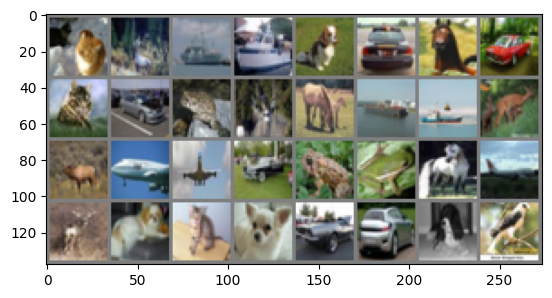

In [7]:
# functions to show an image from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)

In [ ]:
# Architecture design based on the instructions given in the assignments
class FaizanNet(nn.Module):
  """
  FaizanNet - a custom convolutional neural network for image classification based on CIFAR-10 dataset
  The architecture has been designed based on the registartion number for number of layers and
  selecting the kernel size. The unique number:3 1 3 7  3 3 9

  since the image size is 32x32, I am using all the layers and a pooling layer at the end.

  Parameters
  ----------
  filters: number of convolution kernel in a sequence
  stride: window stride
  padding: whether to pad the image or not to increase the spatail dimensions
  use_dropout: dropout to avoid overfitting - randomly turning off some neurons
  use_batchNorm: normalize the feature map obtained at the each layer for faster convergence and scaling the features
  with learnable sigma and gamma values
  input_shape: shape of the input image
  training: mode
  """
  def __init__(self, filters: list, stride: int = 1, padding: int = 0,
               input_shape = (3, 32, 32), training = True):
    super(FaizanNet, self).__init__()
    self.training = training
    self.filters = filters
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size =    self.filters[0],
                           stride = stride)
    self.bn1 = nn.BatchNorm2d(16)

    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size =   self.filters[1],
                           stride = stride)
    self.bn2 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size =   self.filters[2],
                           stride = stride)
    self.bn3 = nn.BatchNorm2d(64)

    self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size =  self.filters[3],
                           stride = stride)
    self.bn4 = nn.BatchNorm2d(128)

    self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = self.filters[4],
                           stride = stride)
    self.bn5 = nn.BatchNorm2d(256)

    self.conv6 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = self.filters[5],
                           stride = stride)
    self.bn6 = nn.BatchNorm2d(512)

    self.conv7 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size =  self.filters[6],
                           stride = stride)
    self.bn7 = nn.BatchNorm2d(512)

    self.pooling = nn.MaxPool2d(2, 2)

    n_size = self._get_conv_output(input_shape)

    self.linear1 = nn.Linear(n_size, 512)
    self.dropout1 = nn.Dropout(p = 0.25)

    self.linear2 = nn.Linear(512, 256)
    self.dropout2 = nn.Dropout(p = 0.3)

    self.out = nn.Linear(256, 10)
    self.sigmoid = nn.Sigmoid()

  def _get_conv_output(self, shape):
    bs = 1
    input = Variable(torch.rand(bs, *shape))
    output_feat = self._forward_features(input)
    n_size = output_feat.data.view(bs, -1).size(1)
    return n_size

  def _forward_features(self, x):
    out0 = x
    out1 = F.relu(self.bn1(self.conv1(out0)))
    out2 = F.relu(self.bn2(self.conv2(out1)))
    out3 = F.relu(self.bn3(self.conv3(out2)))
    out4 = F.relu(self.bn4(self.conv4(out3)))
    out5 = F.relu(self.bn5(self.conv5(out4)))
    out6 = F.relu(self.bn6(self.conv6(out5)))
    out7 = F.relu(self.bn7(self.conv7(out6)))
    out = self.pooling(out7)
    return out

  def forward(self, x):
    features = self._forward_features(x)
    flattened_features = features.view(features.size(0), -1)
    fc_output1 = F.relu(self.linear1(flattened_features))
    fc_dropout = F.dropout(fc_output1, training=self.training)
    fc_output2 = F.relu(self.linear2(fc_dropout))
    fc_dropout2 = F.dropout(fc_output2, training=self.training)
    output = self.out(fc_dropout2)
    output = self.sigmoid(output)
    return output


In [ ]:
def log_image_table(images, predicted, labels, probs):
  """
  Create a log table for experiment comparison
  Args:
    images: torch.tensor
    predicted: torch.tensor
    labels: torch.tensor
    probs: torch.tensor
  """

  # Create a wandb Table to log images, labels and predictions
  table = wandb.Table(columns=["image", "pred", "target"]+[f"score_{i}" for i in range(10)])
  for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
      table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
  wandb.log({"predictions_table":table}, commit=False)

In [ ]:
filters = [3, 1, 3, 7,  3, 3, 9]
model = FaizanNet(filters = filters)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def train(model, criterion, optimizer, train_loader, val_loader, max_epochs, device, val_every=1,
          log_images = True, batch_idx = 0):
  """
  train the model on the cifar 10 dataset

  parameters
  ---------
  model: nn.Module
  criterion: torch.nn.CrossEntropyLoss
  optimizer: torch.optim.SGD
  train_loader: torch.uitls.data.DataLoader
  val_loader: torch.utils.data.DataLoader
  max_epochs: int
  device: str
  """
  # training
  model.to(device)
  model.train()
  train_loss = []
  val_loss = []
  val_accs = []
  val_ps = []
  val_rs = []
  epochs = []
  best_loss = np.inf
  wandb.init(
        project="CIFAR-10 dataset training",
        config={
            "epochs": max_epochs,
            "batch_size": train_loader.batch_size,
            "lr": 0.1,
            "dropout": [0.25, 0.3],
            })
  for epoch in range(max_epochs):
    epoch_loss = 0
    prog_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{max_epochs} - Training')
    for batch_idx, data in enumerate(prog_bar):
      images, labels = data
      predictions = model(images.to(device))
      loss = criterion(predictions, labels.to(device))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss += loss
      avg_running_loss = epoch_loss/(batch_idx + 1)
      prog_bar.set_postfix({'Running Loss': avg_running_loss.detach().cpu().numpy()}, refresh=True)
    avg_epoch_loss = epoch_loss/len(train_loader)
    train_loss.append(avg_epoch_loss)
    epochs.append(epoch)

    # validating
    model.eval()
    with torch.no_grad():
      epoch_val_loss = 0
      accs = 0
      precisions = 0
      recalls = 0
      i = 0
      val_prog_bar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{max_epochs} - Validation')
      for i, (images, labels) in enumerate(val_prog_bar):
        scores = model(images.to(device))
        loss = criterion(scores, labels.to(device))
        epoch_val_loss += loss
        pred = torch.argmax(scores, 1)
        pred = pred.cpu().numpy()
        labels = labels.cpu().numpy()
        acc = accuracy_score(labels, pred)
        precision = precision_score(labels, pred, average = 'micro')
        recall = recall_score(labels, pred, average = 'micro')
        accs += acc
        precisions += precision
        recalls += recall
        val_prog_bar.set_postfix({'Running Loss': epoch_val_loss.cpu().numpy()/(i + 1), 'Running accuracy': accs/ (i + 1)}, refresh=True)
        if i==batch_idx and log_images:
                log_image_table(images, pred, labels, scores.softmax(dim=1))

      avg_val_epoch_loss = epoch_val_loss/len(val_loader)
      if avg_val_epoch_loss < best_loss:
        best_loss = avg_val_epoch_loss
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "val_loss": avg_val_epoch_loss},
            f'lr1e-2_FaizanNet_{device}.pth')

      precisions = precisions/len(val_loader)
      recalls = recalls/len(val_loader)
      accs = accs/ len(val_loader)
      metrics = { "train/train_loss": avg_epoch_loss,
                  "train/epoch": epoch,
                  "test/test_loss": avg_val_epoch_loss,
                  "test/test_accuracy": accs,
                  "test/test_precision": precisions,
                  "test/test_recall": recalls
               }
      wandb.log(metrics)
      val_loss.append(avg_val_epoch_loss)
      val_accs.append(accs)
      val_ps.append(precisions)
      val_rs.append(recalls)

      tqdm.write(f'Epoch {epoch + 1}/{max_epochs}, '
               f'Training Loss: {avg_epoch_loss:.4f}, '
               f'Validation Loss: {avg_val_epoch_loss:.4f}, '
               f'Validation Accuracy: {100 * accs:.2f}%')

  wandb.finish()
  return (train_loss, val_loss, val_accs, val_ps, val_rs)

In [ ]:
train_loss, val_loss, val_accs, val_ps, val_rs = train(model, criterion, optimizer, train_loader, test_loader,
                                                       max_epochs = 50, device = device, val_every = 1)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 30.40it/s, Running Loss=1.9, Running accuracy=0.427]


Epoch 1/50, Training Loss: 2.0479, Validation Loss: 1.9023, Validation Accuracy: 42.67%


Epoch 2/50 - Validation: 100%|██████████| 312/312 [00:12<00:00, 24.63it/s, Running Loss=1.84, Running accuracy=0.478]


Epoch 2/50, Training Loss: 1.9053, Validation Loss: 1.8440, Validation Accuracy: 47.79%


Epoch 3/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 28.05it/s, Running Loss=1.8, Running accuracy=0.525]


Epoch 3/50, Training Loss: 1.8312, Validation Loss: 1.8012, Validation Accuracy: 52.52%


Epoch 4/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 29.11it/s, Running Loss=1.78, Running accuracy=0.578]


Epoch 4/50, Training Loss: 1.7919, Validation Loss: 1.7767, Validation Accuracy: 57.82%


Epoch 5/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 28.01it/s, Running Loss=1.75, Running accuracy=0.61]


Epoch 5/50, Training Loss: 1.7560, Validation Loss: 1.7463, Validation Accuracy: 60.96%


Epoch 6/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.95it/s, Running Loss=1.74, Running accuracy=0.612]


Epoch 6/50, Training Loss: 1.7290, Validation Loss: 1.7396, Validation Accuracy: 61.22%


Epoch 7/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 26.65it/s, Running Loss=1.74, Running accuracy=0.626]


Epoch 7/50, Training Loss: 1.7070, Validation Loss: 1.7362, Validation Accuracy: 62.55%


Epoch 8/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 29.14it/s, Running Loss=1.71, Running accuracy=0.657]


Epoch 8/50, Training Loss: 1.6854, Validation Loss: 1.7065, Validation Accuracy: 65.71%


Epoch 9/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 28.10it/s, Running Loss=1.72, Running accuracy=0.643]


Epoch 9/50, Training Loss: 1.6664, Validation Loss: 1.7172, Validation Accuracy: 64.29%


Epoch 10/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 30.29it/s, Running Loss=1.68, Running accuracy=0.702]


Epoch 10/50, Training Loss: 1.6476, Validation Loss: 1.6770, Validation Accuracy: 70.20%


Epoch 11/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.76it/s, Running Loss=1.67, Running accuracy=0.724]


Epoch 11/50, Training Loss: 1.6303, Validation Loss: 1.6707, Validation Accuracy: 72.40%


Epoch 12/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 30.01it/s, Running Loss=1.67, Running accuracy=0.725]


Epoch 12/50, Training Loss: 1.6143, Validation Loss: 1.6668, Validation Accuracy: 72.53%


Epoch 13/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.73it/s, Running Loss=1.69, Running accuracy=0.706]


Epoch 13/50, Training Loss: 1.5991, Validation Loss: 1.6865, Validation Accuracy: 70.58%


Epoch 14/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 29.28it/s, Running Loss=1.65, Running accuracy=0.746]


Epoch 14/50, Training Loss: 1.5844, Validation Loss: 1.6515, Validation Accuracy: 74.58%


Epoch 15/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.42it/s, Running Loss=1.66, Running accuracy=0.746]


Epoch 15/50, Training Loss: 1.5706, Validation Loss: 1.6588, Validation Accuracy: 74.64%


Epoch 16/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.79it/s, Running Loss=1.66, Running accuracy=0.753]


Epoch 16/50, Training Loss: 1.5579, Validation Loss: 1.6576, Validation Accuracy: 75.27%


Epoch 17/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 29.15it/s, Running Loss=1.66, Running accuracy=0.756]


Epoch 17/50, Training Loss: 1.5462, Validation Loss: 1.6592, Validation Accuracy: 75.61%


Epoch 18/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.53it/s, Running Loss=1.66, Running accuracy=0.753]


Epoch 18/50, Training Loss: 1.5378, Validation Loss: 1.6585, Validation Accuracy: 75.32%


Epoch 19/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.83it/s, Running Loss=1.66, Running accuracy=0.756]


Epoch 19/50, Training Loss: 1.5290, Validation Loss: 1.6574, Validation Accuracy: 75.58%


Epoch 20/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 29.95it/s, Running Loss=1.66, Running accuracy=0.769]


Epoch 20/50, Training Loss: 1.5211, Validation Loss: 1.6577, Validation Accuracy: 76.93%


Epoch 21/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 26.73it/s, Running Loss=1.66, Running accuracy=0.76]


Epoch 21/50, Training Loss: 1.5141, Validation Loss: 1.6645, Validation Accuracy: 76.02%


Epoch 22/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.04it/s, Running Loss=1.66, Running accuracy=0.766]


Epoch 22/50, Training Loss: 1.5081, Validation Loss: 1.6587, Validation Accuracy: 76.63%


Epoch 23/50 - Validation: 100%|██████████| 312/312 [00:13<00:00, 22.87it/s, Running Loss=1.65, Running accuracy=0.777]


Epoch 23/50, Training Loss: 1.5032, Validation Loss: 1.6542, Validation Accuracy: 77.68%


Epoch 24/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 26.71it/s, Running Loss=1.66, Running accuracy=0.772]


Epoch 24/50, Training Loss: 1.4988, Validation Loss: 1.6576, Validation Accuracy: 77.24%


Epoch 25/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 26.12it/s, Running Loss=1.66, Running accuracy=0.774]


Epoch 25/50, Training Loss: 1.4937, Validation Loss: 1.6599, Validation Accuracy: 77.43%


Epoch 26/50 - Validation: 100%|██████████| 312/312 [00:14<00:00, 21.44it/s, Running Loss=1.66, Running accuracy=0.772]


Epoch 26/50, Training Loss: 1.4899, Validation Loss: 1.6641, Validation Accuracy: 77.20%


Epoch 27/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 26.35it/s, Running Loss=1.66, Running accuracy=0.773]


Epoch 27/50, Training Loss: 1.4878, Validation Loss: 1.6647, Validation Accuracy: 77.34%


Epoch 28/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 28.13it/s, Running Loss=1.67, Running accuracy=0.769]


Epoch 28/50, Training Loss: 1.4857, Validation Loss: 1.6685, Validation Accuracy: 76.88%


Epoch 29/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.17it/s, Running Loss=1.69, Running accuracy=0.746]


Epoch 29/50, Training Loss: 1.4854, Validation Loss: 1.6934, Validation Accuracy: 74.60%


Epoch 30/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.04it/s, Running Loss=1.67, Running accuracy=0.773]


Epoch 30/50, Training Loss: 1.4824, Validation Loss: 1.6696, Validation Accuracy: 77.27%


Epoch 31/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 28.39it/s, Running Loss=1.67, Running accuracy=0.773]


Epoch 31/50, Training Loss: 1.4824, Validation Loss: 1.6741, Validation Accuracy: 77.30%


Epoch 32/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.94it/s, Running Loss=1.67, Running accuracy=0.771]


Epoch 32/50, Training Loss: 1.4804, Validation Loss: 1.6735, Validation Accuracy: 77.11%


Epoch 33/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.49it/s, Running Loss=1.67, Running accuracy=0.772]


Epoch 33/50, Training Loss: 1.4791, Validation Loss: 1.6730, Validation Accuracy: 77.16%


Epoch 34/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.31it/s, Running Loss=1.67, Running accuracy=0.782]


Epoch 34/50, Training Loss: 1.4776, Validation Loss: 1.6734, Validation Accuracy: 78.25%


Epoch 35/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 29.80it/s, Running Loss=1.67, Running accuracy=0.774]


Epoch 35/50, Training Loss: 1.4781, Validation Loss: 1.6746, Validation Accuracy: 77.37%


Epoch 36/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.23it/s, Running Loss=1.67, Running accuracy=0.781]


Epoch 36/50, Training Loss: 1.4760, Validation Loss: 1.6682, Validation Accuracy: 78.06%


Epoch 37/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.18it/s, Running Loss=1.67, Running accuracy=0.783]


Epoch 37/50, Training Loss: 1.4754, Validation Loss: 1.6693, Validation Accuracy: 78.32%


Epoch 38/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.00it/s, Running Loss=1.67, Running accuracy=0.781]


Epoch 38/50, Training Loss: 1.4749, Validation Loss: 1.6688, Validation Accuracy: 78.11%


Epoch 39/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 28.31it/s, Running Loss=1.67, Running accuracy=0.776]


Epoch 39/50, Training Loss: 1.4745, Validation Loss: 1.6737, Validation Accuracy: 77.64%


Epoch 40/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 28.41it/s, Running Loss=1.67, Running accuracy=0.772]


Epoch 40/50, Training Loss: 1.4770, Validation Loss: 1.6684, Validation Accuracy: 77.18%


Epoch 41/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 29.03it/s, Running Loss=1.67, Running accuracy=0.782]


Epoch 41/50, Training Loss: 1.4754, Validation Loss: 1.6713, Validation Accuracy: 78.19%


Epoch 42/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 29.94it/s, Running Loss=1.67, Running accuracy=0.781]


Epoch 42/50, Training Loss: 1.4749, Validation Loss: 1.6742, Validation Accuracy: 78.05%


Epoch 43/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.95it/s, Running Loss=1.68, Running accuracy=0.786]


Epoch 43/50, Training Loss: 1.4743, Validation Loss: 1.6752, Validation Accuracy: 78.63%


Epoch 44/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.16it/s, Running Loss=1.67, Running accuracy=0.785]


Epoch 44/50, Training Loss: 1.4740, Validation Loss: 1.6729, Validation Accuracy: 78.49%


Epoch 45/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.01it/s, Running Loss=1.68, Running accuracy=0.778]


Epoch 45/50, Training Loss: 1.4735, Validation Loss: 1.6808, Validation Accuracy: 77.83%


Epoch 46/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 28.37it/s, Running Loss=1.68, Running accuracy=0.777]


Epoch 46/50, Training Loss: 1.4739, Validation Loss: 1.6762, Validation Accuracy: 77.70%


Epoch 47/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 28.96it/s, Running Loss=1.67, Running accuracy=0.779]


Epoch 47/50, Training Loss: 1.4742, Validation Loss: 1.6734, Validation Accuracy: 77.87%


Epoch 48/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.74it/s, Running Loss=1.68, Running accuracy=0.771]


Epoch 48/50, Training Loss: 1.4748, Validation Loss: 1.6804, Validation Accuracy: 77.06%


Epoch 49/50 - Validation: 100%|██████████| 312/312 [00:11<00:00, 27.57it/s, Running Loss=1.67, Running accuracy=0.774]


Epoch 49/50, Training Loss: 1.4751, Validation Loss: 1.6749, Validation Accuracy: 77.38%


Epoch 50/50 - Validation: 100%|██████████| 312/312 [00:10<00:00, 28.87it/s, Running Loss=1.67, Running accuracy=0.778]


Epoch 50/50, Training Loss: 1.4755, Validation Loss: 1.6737, Validation Accuracy: 77.84%


test/test_accuracy,▁▂▃▄▅▅▅▅▇▇▆▇▇▇▇▇▇██████▇████████████████
test/test_loss,█▆▅▄▃▃▃▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁▁▁▂▂▂▂▂▂▂▂▂
test/test_precision,▁▂▃▄▅▅▅▅▇▇▆▇▇▇▇▇▇██████▇████████████████
test/test_recall,▁▂▃▄▅▅▅▅▇▇▆▇▇▇▇▇▇██████▇████████████████
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/train_loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/test_accuracy,0.77845
test/test_loss,1.67372
test/test_precision,0.77845
test/test_recall,0.77845
train/epoch,49


# ***Calculate the memory cost and no. of instructions for Alexnet.***


---
AlexNet involves estimating the memory requirements for model parameters, activations during forward and backward passes, and storage for optimization-related variables. Following things add more cost
1. Model parameters
2. Activations during the forward pass
3. Activation during the backward pass (Gradients)
4. Optimization states or updates

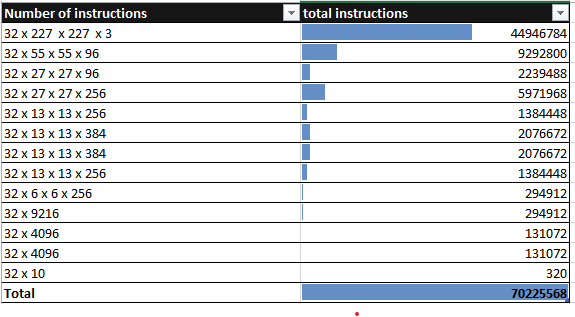
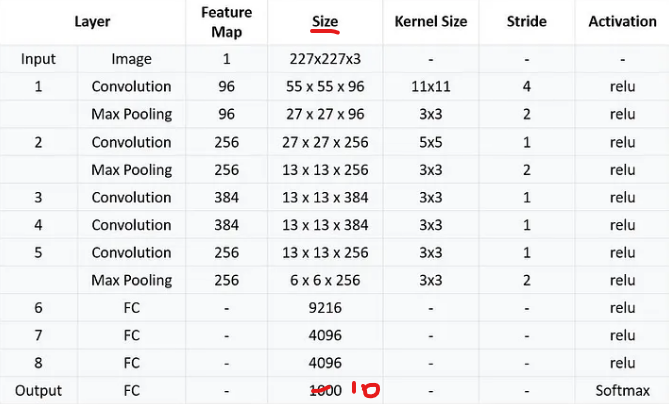


# **Total number of instructions - AlexNet**


---

The foward activation for alexnet is calucatled by the forward acdtivation function and backward activation adn then multiplying the activations by 4 as the number we are considering teh float32 bit number and floating 32 bits has 4 bytes.

As we can say that total nubmer of instructions are  **70225568** and each number is float32 - meaing that each number is 4 byte number and if we multiply the total with the 4 we get **280902272** bytes of memory that we need to store the instructions. If we convert it to MB then we have to divide it by (280902272/1024^2) = **267.89 MB Memory** needed to store the instructions with **227 x 227 x3** image with **32 batch size**. As mentioned each instruction of type 32 bits floating points.




In [ ]:
# calculating model size
import torchvision.models as models
model = models.alexnet()
#calucate number of model paramters
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()

# calculate buffer size
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f} MB'.format(size_all_mb))

model size: 233.081 MB


https://discuss.pytorch.org/t/finding-model-size/130275, more information on pytorch forum. So the total size becomes 267.89 * 2 + 233 MB = 768.78 MB


## **Core i3 PC processing** Task 3


let's convert the clock speed to operations per second:

Clock Speed=3.5 GHz=3.5×109 HzClock Speed=3.5GHz=3.5×109Hz

Now, let's assume a very simplified scenario where each core can perform one floating-point operation per cycle. This is a significant oversimplification, as modern CPUs are much more complex, but it gives a rough idea.

Operations per Second per Core=3.5×109 HzOperations per Second per Core=3.5×109Hz

Now, since there are 4 cores:

Total Operations per Second=4×3.5×109 HzTotal Operations per Second=4×3.5×109H

    input size: 224x224x3 (RGB image)
    Convolutional layers: 3 (with a reduced number of filters for simplicity)
    Fully connected layers: 2 (with a reduced number of neurons for simplicity)

 The actual AlexNet is much more complex with larger layer sizes and additional details.

Now, let's estimate the FLOPS for each layer and sum them up:

    Convolutional layers:
        Assume a reduced filter size of 3x3.
        Assume 16 filters in each convolutional layer (this is a simplification).
        Stride = 1, no padding (simplified).
        Number of FLOPS per convolution: 2×filter size2×input channels×output channels2×filter size2×input channels×output channels
        Total FLOPS for three convolutional layers: 3×2×32×3×163×2×32×3×16

    Fully connected layers:
        Assume a reduced number of neurons (e.g., 128 neurons in each layer).
        Number of FLOPS per fully connected layer: 2×input neurons×output neurons2×input neurons×output neurons
        Total FLOPS for two fully connected layers: 2×12822×1282

    Calculate Total FLOPS:
        Use the previously discussed FLOPS estimates for the simplified AlexNet-like model.

    Calculate Time:
        Time (in seconds) for one forward pass = Total FLOPSCore i3 clock speedCore i3 clock speedTotal FLOPS​